In [2]:
import argparse
import logging
import math
import os
import random
from pathlib import Path

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, deprecate, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

#### load local model

In [109]:
pipe = StableDiffusionPipeline.from_pretrained("my_train_results")
pipe = pipe.to("cuda")    
pipe.safety_checker = None
pipe.requires_safety_checker = False

In [110]:
text_prompt = "A man is jumping"

#### Normal Inference

In [5]:
result = pipe(text_prompt,height=512,width=512,num_images_per_prompt=5)

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
result.images

[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [7]:
image1 = result.images[0]

In [8]:
import numpy as np

pixel_values = np.array(image1)

In [9]:
pixel_values

array([[[125, 126,  88],
        [118, 126,  79],
        [121, 126,  73],
        ...,
        [ 96,  51,  56],
        [ 94,  58,  66],
        [109,  68,  83]],

       [[125, 125,  83],
        [116, 126,  69],
        [119, 134,  59],
        ...,
        [ 84,  31,  34],
        [ 81,  46,  45],
        [ 96,  58,  61]],

       [[124, 131,  78],
        [121, 134,  54],
        [129, 143,  42],
        ...,
        [ 77,   9,  11],
        [ 80,  27,  35],
        [ 93,  43,  48]],

       ...,

       [[ 96, 111,  91],
        [ 79, 104,  87],
        [ 60,  93,  72],
        ...,
        [ 35,   2,   5],
        [ 53,  27,  30],
        [ 76,  48,  50]],

       [[ 91, 108,  93],
        [ 80,  98,  91],
        [ 64,  87,  80],
        ...,
        [ 63,  27,  30],
        [ 73,  48,  48],
        [ 88,  64,  65]],

       [[ 97, 109, 101],
        [ 90, 100, 107],
        [ 74,  93,  96],
        ...,
        [ 91,  55,  68],
        [ 92,  68,  81],
        [106,  79,  88]]

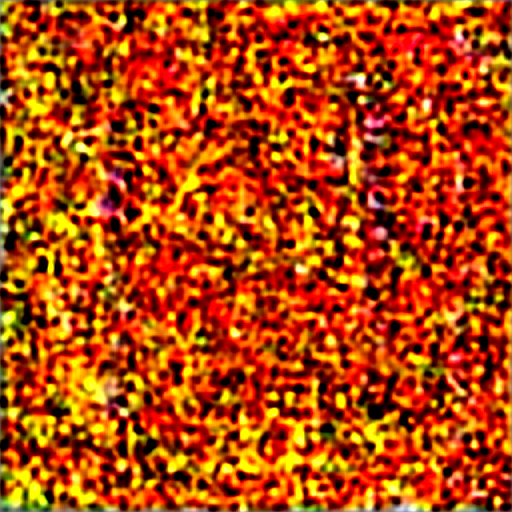

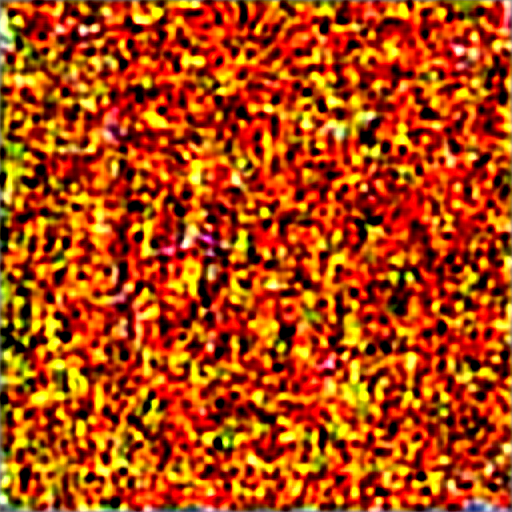

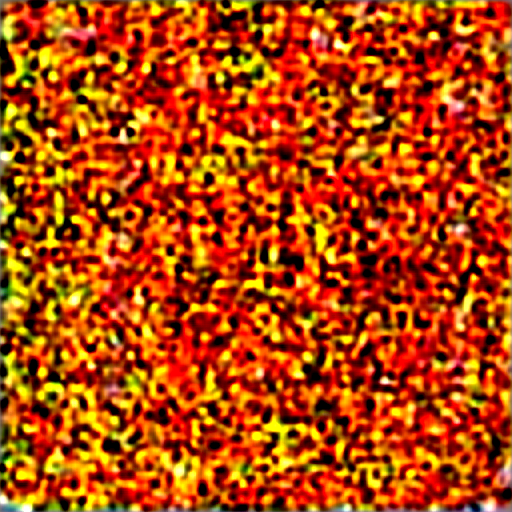

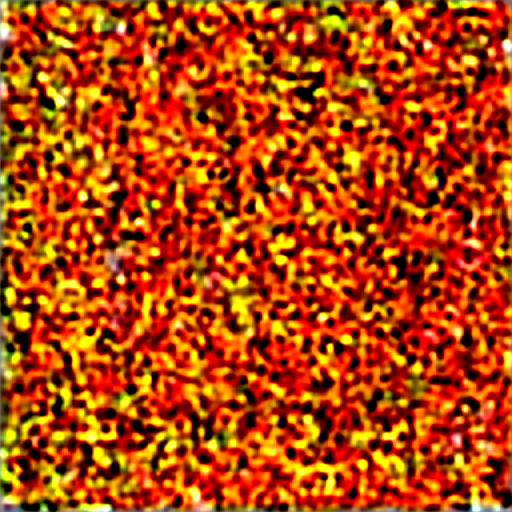

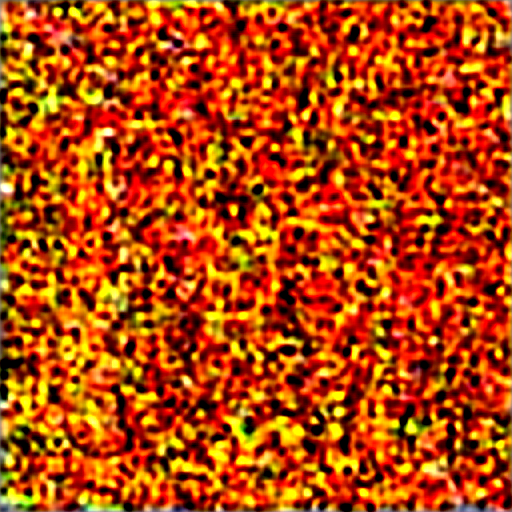

In [10]:
for idx,img in enumerate(result.images):
    # img_name = date_time+"_"+str(idx)+".png"
    # img.save(os.path.join(folder,img_name))
    img.show()

#### For a noise test

In [88]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorboard

In [138]:
pixel_values = np.random.randint(0,8,size=(3,224,224))

pixel_values[0] = 0
pixel_values[1] = 234
pixel_values[2] = 0

In [139]:
pixel_values[0],pixel_values[1]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234],
        ...,
        [234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234]]))

In [140]:
pixel_values = pixel_values.transpose(2,1,0)

In [141]:
pixel_values

array([[[  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0],
        ...,
        [  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0]],

       [[  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0],
        ...,
        [  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0]],

       [[  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0],
        ...,
        [  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0]],

       ...,

       [[  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0],
        ...,
        [  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0]],

       [[  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0],
        ...,
        [  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0]],

       [[  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0],
        ...,
        [  0, 234,   0],
        [  0, 234,   0],
        [  0, 234,   0]]

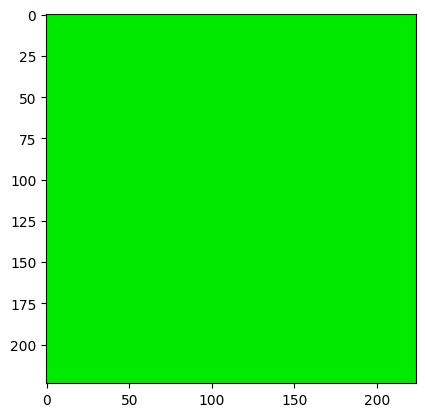

In [142]:
plt.imshow(pixel_values)

#### Generator Noise according to the noise

In [165]:
pretrained_path = "./my_train_results"

In [166]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained(pretrained_path, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained(pretrained_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_path, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(pretrained_path, subfolder="unet")

# another Scheduler
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained(pretrained_path, subfolder="scheduler")

In [167]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [316]:
text_prompt = "A photo of a dog"

In [322]:
prompt = [text_prompt]*10
height = 32  # default height of Stable Diffusion
width = 32  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

In [359]:
prompt

['A photo of a dog',
 'A photo of a dog',
 'A photo of a dog',
 'A photo of a dog',
 'A photo of a dog',
 'A photo of a dog',
 'A photo of a dog',
 'A photo of a dog',
 'A photo of a dog',
 'A photo of a dog']

In [360]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")  # [bs:1,seq_len:77]
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]  # [bs:1,seq_len:77,embedding_dim:768]

In [361]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),  # here not use the recommended `config`, goes wrong
    generator=generator,
)
latents = latents.to(torch_device)  
print(latents.shape)

torch.Size([10, 4, 4, 4])


/tmp/ipykernel_1029706/3265786468.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),  # here not use the recommended `config`, goes wrong


In [362]:
latents = latents * scheduler.init_noise_sigma
print(latents.shape)

torch.Size([10, 4, 4, 4])


In [363]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents])
    # print(latent_model_input.shape)  # [bs:2, channel:4, latent_h: 64, latent_w: 64]

    # latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    # print(latent_model_input.shape)  # same shape of latent_model_input

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    # print(noise_pred.shape) # same shape of latent_model_input
        
    # perform guidance
    noise_pred_text = noise_pred.chunk(2)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    break

  0%|          | 0/100 [00:00<?, ?it/s]

In [364]:
latents.shape

torch.Size([10, 4, 4, 4])

In [365]:
noise_pred.shape

torch.Size([10, 4, 4, 4])

In [304]:
with torch.no_grad():
    vae_decoding = vae.decode(noise_pred).sample

limit to epsilon

In [305]:
norm_type = 'l2'
epsilon = 16
if norm_type == 'l2':
    temp = torch.norm(vae_decoding.view(vae_decoding.shape[0], -1), dim=1).view(-1, 1, 1, 1)
    vae_decoding = vae_decoding * epsilon / temp
else:
    vae_decoding = torch.clamp(vae_decoding, -epsilon / 255, epsilon / 255)

In [306]:
noise = vae_decoding

In [307]:
noise

tensor([[[[-7.5119e-01, -2.2107e-01, -4.9395e-01,  ..., -2.9965e-01,
            2.3516e-01, -9.9476e-02],
          [-3.8768e-01, -7.8020e-02,  1.5849e-01,  ..., -3.6296e-01,
            3.8107e-01, -9.4073e-02],
          [-9.1060e-02, -1.7909e-01, -9.1065e-02,  ...,  1.8222e-01,
            1.4273e-01, -1.7174e-01],
          ...,
          [-3.2493e-01,  3.7704e-01, -1.7729e-03,  ...,  2.5357e-01,
            2.6863e-01,  4.8330e-02],
          [-7.0363e-02,  1.2289e-01,  3.7130e-02,  ...,  2.0110e-01,
            3.2236e-01,  3.3329e-01],
          [-1.1287e+00,  4.9343e-01,  7.1035e-02,  ..., -3.2696e-02,
           -1.9980e-01,  4.0847e-01]],

         [[-6.0429e-01, -1.0655e-01, -5.2014e-01,  ..., -3.7678e-01,
            3.3186e-01,  3.0250e-02],
          [-4.0793e-01, -2.9643e-01,  1.4750e-01,  ..., -5.4833e-01,
            2.3392e-01,  2.2332e-01],
          [ 7.5695e-03, -4.6281e-01, -1.7938e-01,  ...,  7.9423e-03,
            8.6229e-02, -1.6015e-01],
          ...,
     

In [279]:
noise.shape

torch.Size([1, 3, 32, 32])

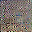

In [280]:
noise = (noise / 2 + 0.5).clamp(0, 1)
noise = noise.detach().cpu().permute(0, 2, 3, 1).numpy()
noise = (noise * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in noise]
pil_images[0]

In [281]:
noise

array([[[[ 32,  50,  72],
         [ 99, 114, 160],
         [ 64,  61,  84],
         ...,
         [ 89,  80,  77],
         [157, 170, 160],
         [115, 131, 119]],

        [[ 78,  76,  99],
         [118,  90, 103],
         [148, 146, 141],
         ...,
         [ 81,  57,  60],
         [176, 157, 149],
         [116, 156, 152]],

        [[116, 128, 135],
         [105,  68,  88],
         [116, 105, 103],
         ...,
         [151, 129, 141],
         [146, 138, 120],
         [106, 107, 105]],

        ...,

        [[ 86,  80,  62],
         [176, 146, 132],
         [127,  95,  94],
         ...,
         [160, 153, 117],
         [162, 149, 131],
         [134, 126,  98]],

        [[119, 116,  98],
         [143, 120, 129],
         [132, 141, 131],
         ...,
         [153, 135, 102],
         [169, 141, 125],
         [170, 150, 137]],

        [[  0,   0,   0],
         [191, 185, 152],
         [137, 126, 113],
         ...,
         [123, 110,  94],
        

In [414]:
def generate_noise(prompts):
    batch_size = len(prompts)
    text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")  # [bs:1,seq_len:77]
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]  # [bs:1,seq_len:77,embedding_dim:768]

    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),  # here not use the recommended `config`, goes wrong
        generator=generator,
    )
    latents = latents.to(torch_device)  
    latents = latents * scheduler.init_noise_sigma
    scheduler.set_timesteps(num_inference_steps)
    
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents])
        # print(latent_model_input.shape)  # [bs:2, channel:4, latent_h: 64, latent_w: 64]
    
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
        # print(latent_model_input.shape)  # same shape of latent_model_input
    
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # print(noise_pred.shape) # same shape of latent_model_input
            
        # perform guidance
        noise_pred_text = noise_pred.chunk(2)
    
        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    noise_source = noise_pred
    with torch.no_grad():
        vae_decoding = vae.decode(noise_source).sample
    norm_type = 'l2'
    epsilon = 16
    if norm_type == 'l2':
        temp = torch.norm(vae_decoding.view(vae_decoding.shape[0], -1), dim=1).view(-1, 1, 1, 1)
        vae_decoding = vae_decoding * epsilon / temp
    else:
        vae_decoding = torch.clamp(vae_decoding, -epsilon / 255, epsilon / 255)
    return vae_decoding

#### Cifar10-test

In [415]:
cifar_text_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [416]:
cifar10_prompts = [
    "a photo of "+ cifar_text_dict[key] for key in cifar_text_dict.keys()
]

In [417]:
cifar10_prompts

['a photo of airplane',
 'a photo of automobile',
 'a photo of bird',
 'a photo of cat',
 'a photo of deer',
 'a photo of dog',
 'a photo of frog',
 'a photo of horse',
 'a photo of ship',
 'a photo of truck']

In [418]:
noises = generate_noise(cifar10_prompts)

/tmp/ipykernel_1029706/3147104040.py:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),  # here not use the recommended `config`, goes wrong


  0%|          | 0/100 [00:00<?, ?it/s]

In [419]:
noises.shape

torch.Size([10, 3, 32, 32])

##### Visualize

In [420]:
from torchvision.utils import make_grid

noise_list = noises.chunk(10)

grid_image = make_grid(noises, nrow=5)

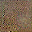

In [424]:
noise = (noises / 2 + 0.5).clamp(0, 1)
noise = noise.detach().cpu().permute(0, 2, 3, 1).numpy()
noise = (noise * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in noise]
pil_images[2]

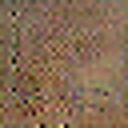

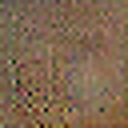

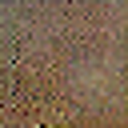

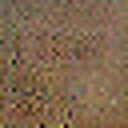

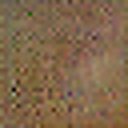

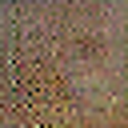

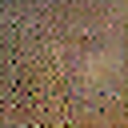

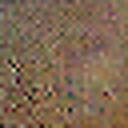

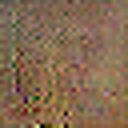

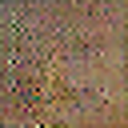

In [430]:
for img in pil_images:
    # print(type(img))
    big_img = img.resize((128,128))
    big_img.show()

#### Vae recover test

In [2]:
import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, deprecate, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

In [3]:
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")

In [21]:
from PIL import Image

test_image = Image.open("./test_image1.png")
# test_image = test_image.resize((224,224))
print(test_image)


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7FDF0D0BC220>


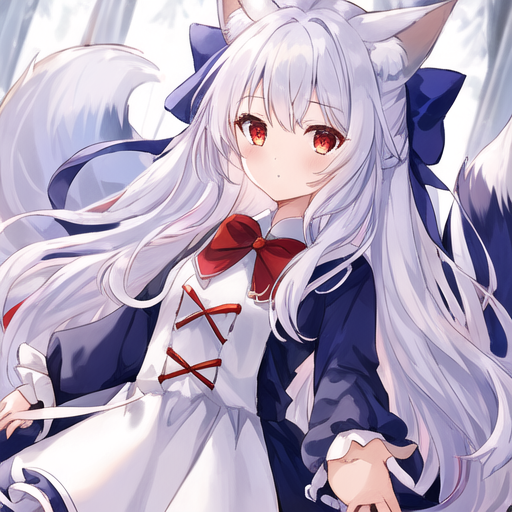

In [22]:
test_image

In [55]:
# transfer to tensor
from torchvision import transforms
from matplotlib import pyplot as plt
image_tensor = transforms.ToTensor()(test_image)

# add batch dimension
image_tensor = image_tensor.unsqueeze(0)

vae.eval()

latent = vae.encode(image_tensor).latent_dist.sample()

vae_decoding = vae.decode(latent).sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 4, 64, 64])


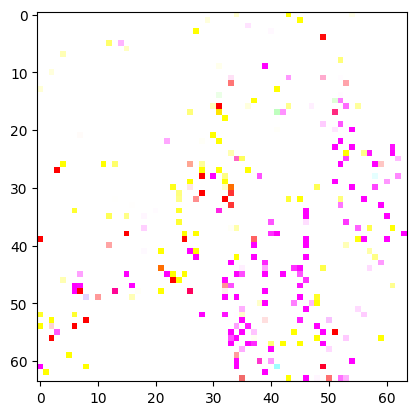

In [56]:
print(latent.shape)
the_image = latent.squeeze().permute(1,2,0).detach().cpu().numpy()
plt.imshow(the_image)

# 4*64*64=16384

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


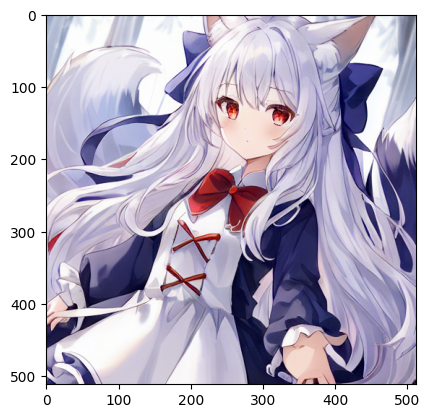

In [57]:
the_image = vae_decoding.squeeze().permute(1,2,0).detach().cpu().numpy()
print(the_image.shape)
plt.imshow(the_image)

# 3*512*512=786432   shorten to 48 times

In [49]:
print(latent.shape)

torch.Size([1, 4, 64, 64])


In [51]:
import torch

latent = torch.randn(latent.shape)

In [53]:
latent_plus_1 = latent
vae_decoding_plus_1 = vae.decode(latent_plus_1).sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


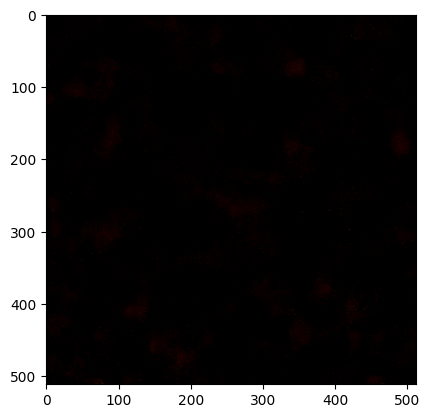

In [54]:
the_image = vae_decoding_plus_1.squeeze().permute(1,2,0).detach().cpu().numpy()
print(the_image.shape)
plt.imshow(the_image)

# 3*512*512=786432   shorten to 48 times

#### Clip Test

clip from pretrained "clip vit base patch32

In [3]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(
    text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [17]:
from transformers import CLIPConfig, CLIPModel

# Initializing a CLIPConfig with openai/clip-vit-base-patch32 style configuration
configuration = CLIPConfig()

# Initializing a CLIPModel (with random weights) from the openai/clip-vit-base-patch32 style configuration
model = CLIPModel(configuration)

# Accessing the model configuration
configuration = model.config

# We can also initialize a CLIPConfig from a CLIPTextConfig and a CLIPVisionConfig
from transformers import CLIPTextConfig, CLIPVisionConfig

# Initializing a CLIPText and CLIPVision configuration
config_text = CLIPTextConfig()
config_vision = CLIPVisionConfig()

config = CLIPConfig.from_text_vision_configs(config_text, config_vision)

In [18]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [20]:
model.train()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [19]:
inputs = processor(
    text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
)

outputs = model(**inputs)


In [23]:
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score


In [25]:
logits_per_image

tensor([[0.0919, 0.2481]], grad_fn=<TBackward0>)

In [27]:
loss = logits_per_image[0][0]-logits_per_image[0][1]

In [28]:
loss.backward()

In [43]:
model.vision_model.encoder.layers[0].mlp.fc1.weight.grad

tensor([[ 3.6158e-04,  2.7328e-04, -5.3062e-04,  ...,  1.0871e-03,
          2.9105e-04, -8.6031e-04],
        [ 3.0886e-04,  3.3954e-04, -5.6434e-04,  ...,  1.1659e-03,
          3.0088e-04, -9.5835e-04],
        [ 1.5392e-04,  1.5609e-04, -2.4265e-04,  ...,  4.8224e-04,
          1.5223e-04, -3.3379e-04],
        ...,
        [-1.1996e-04, -7.7533e-05, -1.2954e-04,  ...,  4.7395e-04,
         -7.6353e-05, -7.8217e-04],
        [ 2.3195e-04,  2.4616e-04, -5.0092e-05,  ..., -1.1956e-05,
          1.6295e-04,  3.8061e-04],
        [ 2.5203e-05, -1.7956e-05, -7.7114e-05,  ...,  1.0716e-04,
          6.8841e-05, -8.3271e-05]])

In [44]:
from torch.optim import AdamW

In [48]:
optimizer = AdamW(model.parameters())

In [50]:
optimizer.zero_grad()

In [51]:
optimizer.step()

In [52]:
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [53]:
probs

tensor([[0.4610, 0.5390]], grad_fn=<SoftmaxBackward0>)

In [55]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [57]:
test_file_path = '/remote-home/songtianwei/temp/'

In [59]:
test_file_name = '397859981.sdgen_img.npy'

In [60]:
import os

test_path = os.path.join(test_file_path, test_file_name)

In [62]:
import numpy as np

In [63]:
arr = np.load(test_path)

In [71]:
arr.shape

(256, 256, 3)

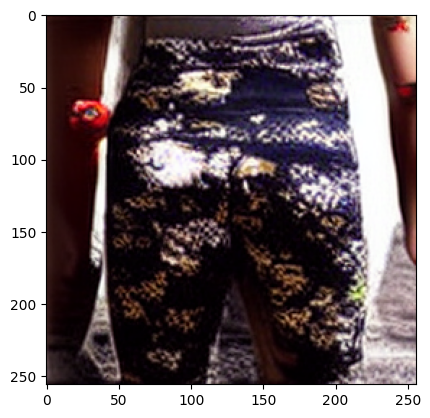

In [72]:
import matplotlib.pyplot as plt

plt.imshow(arr)

#### WebDataset use

In [6]:
import torch
from torch.utils.data import IterableDataset
from torchvision import transforms
import webdataset as wds
from itertools import islice

In [7]:
test_tar_file_path = '/remote-home/songtianwei/temp/39785.tar'

In [8]:
dataset = wds.WebDataset(test_tar_file_path)
repr(next(iter(dataset)))[:200]

'{\'__key__\': \'397850042\', \'__url__\': \'/remote-home/songtianwei/temp/39785.tar\', \'json\': b\'{"NSFW": "UNLIKELY", "similarity": 0.3004233241081238, "LICENSE": "?", "caption": "1.0mm 450mm 600mm 800mm alum'

In [9]:
for i, sample in enumerate(dataset):
    for key, value in sample.items():
        print(key, repr(value)[:50])
    print()
    if i >= 3: break

__key__ '397850042'
__url__ '/remote-home/songtianwei/temp/39785.tar'
json b'{"NSFW": "UNLIKELY", "similarity": 0.30042332410
ori_img.npy b'\x93NUMPY\x01\x00v\x00{\'descr\': \'|u1\', \'for
sdgen_img.npy b'\x93NUMPY\x01\x00v\x00{\'descr\': \'|u1\', \'for
sdgen_info.json b'{"sdgen_prompt": "1.0mm 450mm 600mm 800mm alumin
text b'1.0mm 450mm 600mm 800mm aluminium bubble level'

__key__ '397850000'
__url__ '/remote-home/songtianwei/temp/39785.tar'
json b'{"NSFW": "UNLIKELY", "similarity": 0.36341646313
ori_img.npy b'\x93NUMPY\x01\x00v\x00{\'descr\': \'|u1\', \'for
sdgen_img.npy b'\x93NUMPY\x01\x00v\x00{\'descr\': \'|u1\', \'for
sdgen_info.json b'{"sdgen_prompt": "Techniques-of-the-Selling-Writ
text b'Techniques-of-the-Selling-Writer'

__key__ '397850033'
__url__ '/remote-home/songtianwei/temp/39785.tar'
json b'{"NSFW": "UNLIKELY", "similarity": 0.30300036072
ori_img.npy b'\x93NUMPY\x01\x00v\x00{\'descr\': \'|u1\', \'for
sdgen_img.npy b'\x93NUMPY\x01\x00v\x00{\'descr\': \'|u1\', \'for
sdgen_

In [85]:
dataset.select(1)

#### Try finetuned

In [5]:
from transformers import CLIPTextModel, CLIPTokenizer, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")